In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
from pydub import AudioSegment

C:\Users\dave\anaconda3\envs\haikoo\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
dir_path = r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\set 2.2"
class_names = next(os.walk(dir_path))[1]
class_names

['.ipynb_checkpoints', 'bpain', 'discomfort', 'hungry', 'tired']

In [3]:
class_names.remove('.ipynb_checkpoints')

In [4]:
audio_path = [os.path.join(dir_path, name) for name in class_names]
audio_path

['C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\set 2.2\\bpain',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\set 2.2\\discomfort',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\set 2.2\\hungry',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\set 2.2\\tired']

In [5]:
bpain_audio = glob.glob(os.path.join(audio_path[0], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_path[1], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_path[2], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_path[3], '*.wav'))

In [6]:
audio_num_byclass = {
    'bpain': len(bpain_audio),
    'discomf': len(discomf_audio),
    'hungry': len(hungry_audio),
    'tired': len(tired_audio)
}

for k, v in audio_num_byclass.items():
    print(f'num audio for the class {k}: {v}')

num audio for the class bpain: 63
num audio for the class discomf: 128
num audio for the class hungry: 100
num audio for the class tired: 49


## **Data Imbalance 체크**

<function matplotlib.pyplot.show(close=None, block=None)>

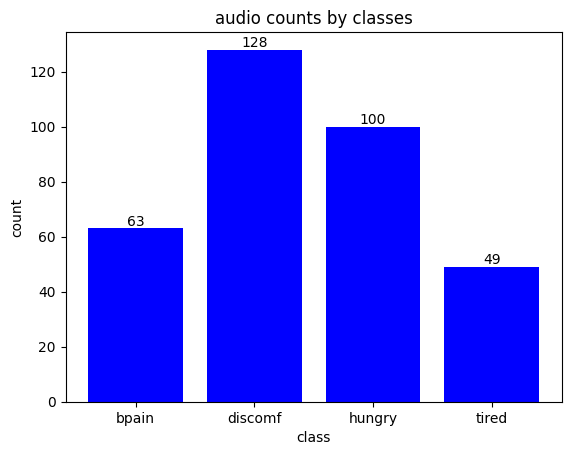

In [7]:
plt.bar(audio_num_byclass.keys(), audio_num_byclass.values(), color ='b')

for class_label, count in audio_num_byclass.items():
    plt.text(class_label, count, str(count), ha='center', va='bottom')

plt.xlabel('class')
plt.ylabel('count')
plt.title('audio counts by classes')
plt.show

## **sampling rate 체크**

In [8]:
bpain_sr = [(librosa.load(audio, sr=None)[1]) for audio in bpain_audio]
discomf_sr = [(librosa.load(audio, sr=None)[1]) for audio in discomf_audio]
hungry_sr = [(librosa.load(audio, sr=None)[1]) for audio in hungry_audio]
tired_sr = [(librosa.load(audio, sr=None)[1]) for audio in tired_audio]

(8000, 48000) (16, 47)
(8000, 48000, 44100) (35, 64, 29)
(8000,) (100,)
(8000, 48000) (24, 25)


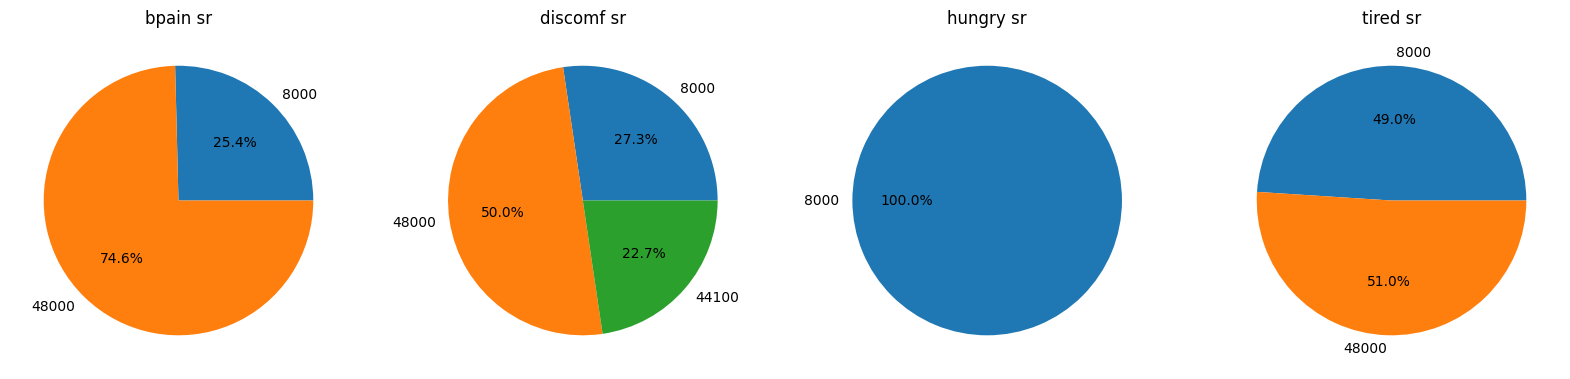

In [9]:
# Sample Rate 측정
from collections import Counter
audio_sr_byclass = {
    'bpain': bpain_sr,
    'discomf': discomf_sr,
    'hungry': hungry_sr,
    'tired': tired_sr
}

# Create a figure with 4 subplots
plt.figure(figsize=(20, 5))

for i, (k, v) in enumerate(audio_sr_byclass.items()):
    # Count the occurrences of each sample rate
    sr_counts = Counter(v)
    labels, counts = zip(*sr_counts.items())
    print(labels, counts)

    # Create a subplot for each class
    plt.subplot(1, 4, i+1)
    plt.pie(counts, labels=labels, autopct ='%.1f%%')
    plt.title(f'{k} sr')

plt.show()

## 오디오 길이 체크

In [10]:
audio_path = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

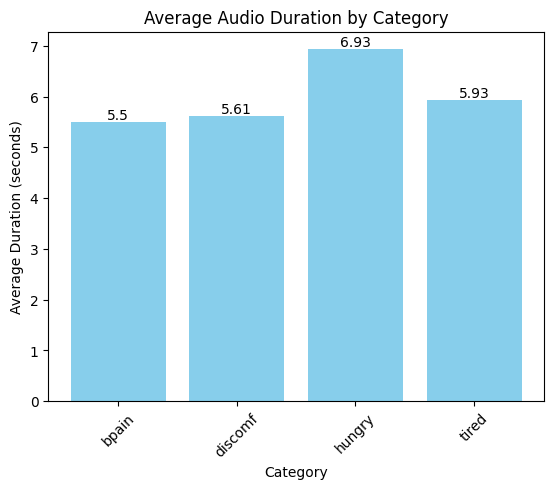

In [11]:
average_durations = {}

# Calculate average durations
for name, audios in audio_path.items():
    total_duration = 0
    for path in audios:
        audio = AudioSegment.from_file(path)
        total_duration += audio.duration_seconds
    average_duration = total_duration / len(audios) if audios else 0
    average_durations[name] = average_duration

# Names and averages for plotting
names = list(average_durations.keys())
averages = list(average_durations.values())

for idx, avg in enumerate(averages):
    avg = '{:.2f}'.format(avg)
    averages[idx] = float(avg)
# Plotting
fig, ax = plt.subplots()
ax.bar(names, averages, color='skyblue')
for name, avg in zip(names, averages):
    plt.text(name, avg, str(avg), ha='center', va='bottom')
ax.set_xlabel('Category')
ax.set_ylabel('Average Duration (seconds)')
ax.set_title('Average Audio Duration by Category')

plt.xticks(rotation=45)
plt.show()

In [12]:
averages

[5.495555555555555, 5.605532206632652, 6.929599999999993, 5.934285714285714]

In [13]:
# 오디오 평균 길이
total_duration = 0

for avg in averages:
    total_duration += avg

print(total_duration/4)

5.991243369118479


## **평균 mel spec EDA**

In [14]:
# Bellypain audio to spectrogram
melspec_belly = []

for path in bpain_audio:
    y, sr = librosa.load(path, sr = 16000, duration=5.0)
    S_db = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    melspec_belly.append(S_db)

In [15]:
melspec_belly_arr = np.array(melspec_belly)

In [16]:
belly_mean_melspec = np.mean(melspec_belly_arr, axis=0)
belly_mean_melspec.shape

(128, 157)

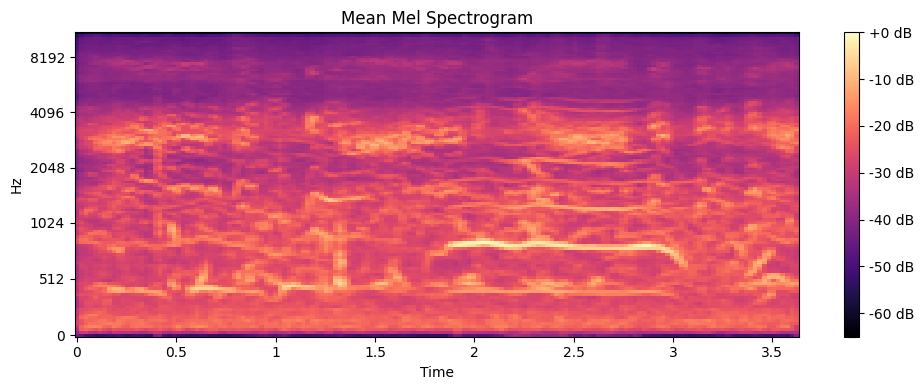

In [17]:
# Assuming mean_melspec is your mean mel spectrogram calculated earlier
plt.figure(figsize=(10, 4))

# Displaying the spectrogram
librosa.display.specshow(librosa.power_to_db(belly_mean_melspec, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mean Mel Spectrogram')
plt.tight_layout()
plt.show()

In [20]:
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr/2)
lower_bound_idx = np.argmin(np.abs(mel_frequencies - 600))
upper_bound_idx = np.argmin(np.abs(mel_frequencies - 1024))

# Extract the part of the mel spectrogram corresponding to this range
target_range = belly_mean_melspec[lower_bound_idx:upper_bound_idx+1, :]

# Now, find the average frequency in this range
# We multiply the magnitude by the frequency to get a weighted sum
weighted_frequencies = np.sum(target_range * mel_frequencies[lower_bound_idx:upper_bound_idx+1, np.newaxis], axis=0)
total_magnitude = np.sum(target_range, axis=0)
average_frequency = np.sum(weighted_frequencies) / np.sum(total_magnitude)

average_frequency

762.2792825001068

In [22]:
# discomf audio to spectrogram
melspec_discomf = []

for path in discomf_audio:
    y, sr = librosa.load(path, sr = 16000, duration=5.0)
    S_db = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    melspec_discomf.append(S_db)

In [23]:
melspec_discomf_arr = np.array(melspec_discomf)
discomf_mean_melspec = np.mean(melspec_discomf_arr, axis=0)
discomf_mean_melspec.shape

(128, 157)

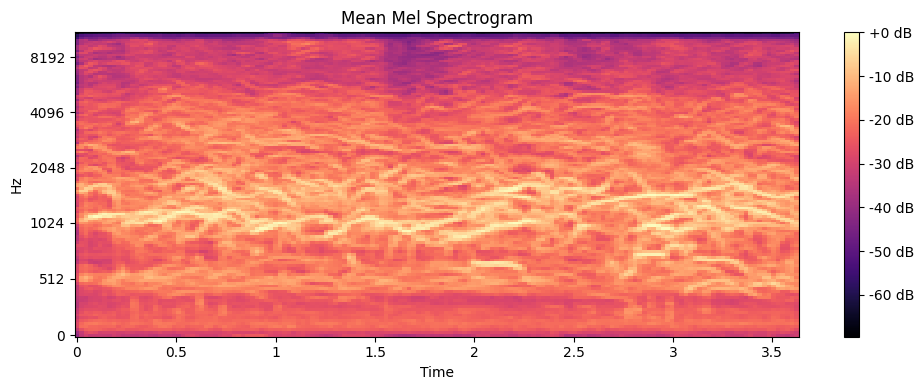

In [24]:
# Assuming mean_melspec is your mean mel spectrogram calculated earlier
plt.figure(figsize=(10, 4))

# Displaying the spectrogram
librosa.display.specshow(librosa.power_to_db(discomf_mean_melspec, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mean Mel Spectrogram')
plt.tight_layout()
plt.show()

In [26]:
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr/2)
lower_bound_idx = np.argmin(np.abs(mel_frequencies - 950))
upper_bound_idx = np.argmin(np.abs(mel_frequencies - 1524))

# Extract the part of the mel spectrogram corresponding to this range
target_range = discomf_mean_melspec[lower_bound_idx:upper_bound_idx+1, :]

# Now, find the average frequency in this range
# We multiply the magnitude by the frequency to get a weighted sum
weighted_frequencies = np.sum(target_range * mel_frequencies[lower_bound_idx:upper_bound_idx+1, np.newaxis], axis=0)
total_magnitude = np.sum(target_range, axis=0)
average_frequency = np.sum(weighted_frequencies) / np.sum(total_magnitude)

average_frequency

1175.4203508177934

In [27]:
# hungry audio to mel spec
melspec_hungry = []

for path in hungry_audio:
    y, sr = librosa.load(path, sr = 16000, duration=5.0)
    S_db = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    melspec_hungry.append(S_db)

In [28]:
melspec_hungry_arr = np.array(melspec_hungry)
hungry_mean_melspec = np.mean(melspec_hungry_arr, axis=0)
hungry_mean_melspec.shape

(128, 157)

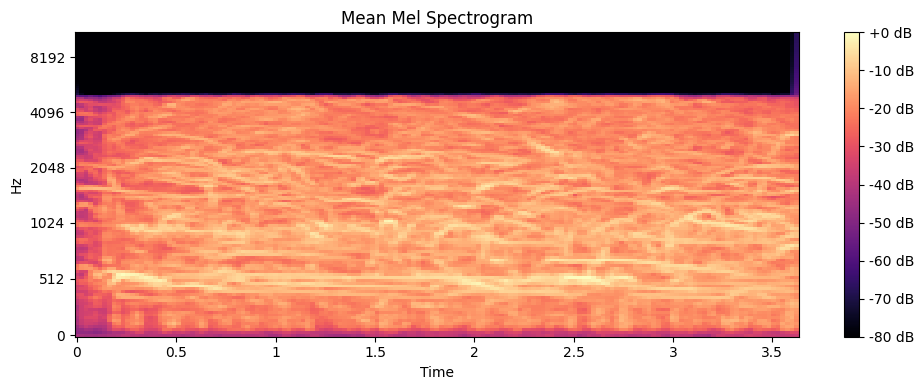

In [29]:
# Assuming mean_melspec is your mean mel spectrogram calculated earlier
plt.figure(figsize=(10, 4))

# Displaying the spectrogram
librosa.display.specshow(librosa.power_to_db(hungry_mean_melspec, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mean Mel Spectrogram')
plt.tight_layout()
plt.show()

In [32]:
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr/2)
lower_bound_idx = np.argmin(np.abs(mel_frequencies - 450))
upper_bound_idx = np.argmin(np.abs(mel_frequencies - 650))

# Extract the part of the mel spectrogram corresponding to this range
target_range = hungry_mean_melspec[lower_bound_idx:upper_bound_idx+1, :]

# Now, find the average frequency in this range
# We multiply the magnitude by the frequency to get a weighted sum
weighted_frequencies = np.sum(target_range * mel_frequencies[lower_bound_idx:upper_bound_idx+1, np.newaxis], axis=0)
total_magnitude = np.sum(target_range, axis=0)
average_frequency = np.sum(weighted_frequencies) / np.sum(total_magnitude)

average_frequency

517.3329038618552

In [33]:
# tired
melspec_tired = []

for path in tired_audio:
    y, sr = librosa.load(path, sr = 16000, duration=5.0)
    S_db = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    melspec_tired.append(S_db)

In [34]:
melspec_tired_arr = np.array(melspec_tired)
tired_mean_melspec = np.mean(melspec_tired_arr, axis=0)
tired_mean_melspec.shape

(128, 157)

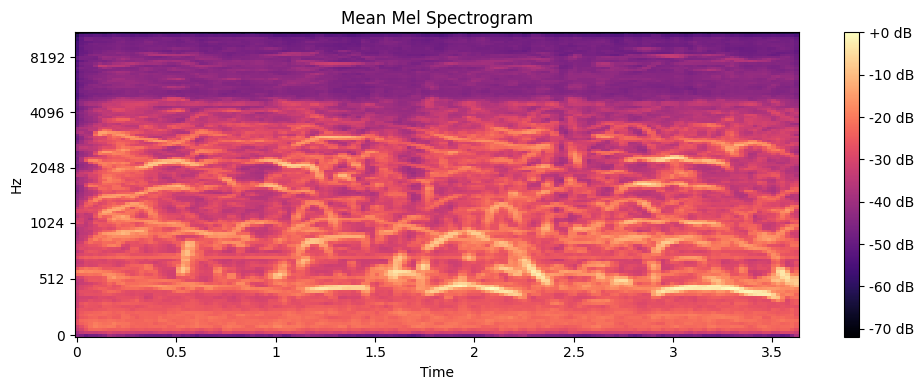

In [35]:
# Assuming mean_melspec is your mean mel spectrogram calculated earlier
plt.figure(figsize=(10, 4))

# Displaying the spectrogram
librosa.display.specshow(librosa.power_to_db(tired_mean_melspec, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mean Mel Spectrogram')
plt.tight_layout()
plt.show()

In [37]:
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr/2)
lower_bound_idx = np.argmin(np.abs(mel_frequencies - 450))
upper_bound_idx = np.argmin(np.abs(mel_frequencies - 1024))

# Extract the part of the mel spectrogram corresponding to this range
target_range = tired_mean_melspec[lower_bound_idx:upper_bound_idx+1, :]

# Now, find the average frequency in this range
# We multiply the magnitude by the frequency to get a weighted sum
weighted_frequencies = np.sum(target_range * mel_frequencies[lower_bound_idx:upper_bound_idx+1, np.newaxis], axis=0)
total_magnitude = np.sum(target_range, axis=0)
average_frequency = np.sum(weighted_frequencies) / np.sum(total_magnitude)

average_frequency

670.4496995256623

In [43]:
target_range.shape

(25, 157)

In [44]:
total_magnitude.shape

(157,)